In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
import pickle
import os

In [153]:
np.random.seed(42)

In [128]:
data = pd.read_csv("../data/formatted_ed2022.csv")

C:\Users\priya\AppData\Local\Temp\ipykernel_36424\1934294881.py:1: DtypeWarning: Columns (88,133,298,393,397,401,405,413,417,421,425,432,433,436,437,440,441,443,444,445,452,453,456,457,460,461,464,465,472,473,476,477,480,481,484,485,492,493,496,497,500,501,503,504,505,512,513,516,517,520,521,523,524,525,532,533,536,537,540,541,543,544,545,552,553,556,557,560,561,563,564,565,571,572,573,575,576,577,579,580,581,583,584,585,591,592,595,596,599,600,603,604,611,612,615,616,619,620,622,623,624,631,635,639,643,651,652,655,656,659,660,662,663,671,672,675,676,679,680,682,683,684,686,687,688,689,690,691,692,694,695,696,698,699,700,702,703,704,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,725,726,727,728,729,730,731,732,734,735,736,738,739,740,742,743,744,746,747,748,749,750,751,752,754,755,756,758,759,760,762,763,764,766,767,768,769,770,771,772,774,775,776,778,779,780,782,783,784,786,787,788,789,790,791,792,794,795,796,798,799,800,802,803,806,807,808,809,810,811,814,815

In [129]:
# Record triage level 1 as level 2, since the paper shows that the model cannot distinguish between these levels
data.loc[data['IMMEDR'] == 'Immediate', 'IMMEDR'] = 'Emergent'

In [130]:
# Impute or drop missing or null values
data = data[~((data['ARREMS'] == 'Blank') | (data['ARREMS'] == 'Unknown'))]
data = data[~(data['INJPOISAD'] == 'Blank')]

data.loc[data['TOTDIAG'] == "'None' box and all item fields are blank", 'TOTDIAG'] = 0
data.loc[data['TOTPROC'] == "'None' box and all item fields are blank", 'TOTPROC'] = 0
data.loc[data['DRUGID1'] == '', 'DRUGID1'] = 'NONE'
data.loc[data['DRUGID2'] == '', 'DRUGID2'] = 'NONE'
data.loc[data['DRUGID3'] == '', 'DRUGID3'] = 'NONE'
data.loc[data['DRUGID4'] == '', 'DRUGID4'] = 'NONE'
data.loc[data['AGE'] == 'Under one year', 'AGE'] = 0
data.loc[data['AGE'] == '94 years and over', 'AGE'] = 94

data['ARREMS'] = data['ARREMS'].map({'Yes': 1, 'No': 0})

In [131]:
data.shape

(9932, 913)

In [132]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data.drop('IMMEDR', axis=1), data[['IMMEDR']], test_size=0.023, random_state=42)

In [133]:
train_X['IMMEDR'] = train_y
train_X.to_csv('train.csv', index=False)
test_X['IMMEDR'] = test_y
test_X.to_csv('test.csv', index=False)

In [265]:
train_X = pd.read_csv('train.csv')
test_X = pd.read_csv('test.csv')
train_y = train_X[['IMMEDR']]
test_y = test_X[['IMMEDR']]

C:\Users\priya\AppData\Local\Temp\ipykernel_36424\2077273.py:1: DtypeWarning: Columns (412,416,420,424,432,436,440,444,451,452,455,456,459,460,463,464,471,472,475,476,479,480,483,484,491,492,495,496,499,500,502,503,504,511,512,515,516,519,520,522,523,524,531,532,535,536,539,540,542,543,544,551,552,555,556,559,560,562,563,564,570,571,572,574,575,576,578,579,580,582,583,584,591,595,599,602,603,610,611,614,615,618,619,622,623,630,634,638,642,650,651,654,655,658,659,661,662,670,671,674,675,678,679,682,683,690,691,694,695,698,699,701,702,703,710,711,712,714,715,716,718,719,720,721,722,724,730,731,734,735,738,739,741,742,743,750,751,754,755,758,759,761,762,763,765,766,767,768,769,770,771,773,774,775,777,778,779,781,782,783,785,786,787,788,789,790,791,793,794,795,797,798,799,801,802,805,806,807,808,809,810,813,814,817,818,821,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,853,854,857,858,861,862,865,866,867,868,869,873,877,881) have mix

In [197]:
features = ['TOTDIAG', 'RFV1', 'ARREMS', 'DRUGID1', 'RFV2', 'CAUSE1', 'RFV3', 'DRUGID2', 'DRUGID4', 'AGE', 'DRUGID3', 'INTENT15', 'INJPOISAD', 'INJURY72', 'TOTPROC']
train_X = train_X[features]
test_X = test_X[features]

In [198]:
train_X.dtypes

TOTDIAG       int64
RFV1         object
ARREMS       object
DRUGID1      object
RFV2         object
CAUSE1       object
RFV3         object
DRUGID2      object
DRUGID4      object
AGE           int64
DRUGID3      object
INTENT15     object
INJPOISAD    object
INJURY72     object
TOTPROC       int64
dtype: object

In [199]:
# Encode categorical variables
categorical_cols = train_X.select_dtypes(include=['object', 'category']).columns.tolist()

In [200]:
train_X_encoded = pd.get_dummies(train_X, columns=categorical_cols, drop_first=True)
test_X_encoded = pd.get_dummies(test_X, columns=categorical_cols, drop_first=True)

In [201]:
train_X_encoded.shape

(9880, 3297)

In [202]:
test_X_encoded.shape

(202, 513)

In [203]:
aligned_test_X_encoded = test_X_encoded.copy()
for col in set(train_X_encoded.columns) - set(test_X_encoded.columns):
    if pd.api.types.is_numeric_dtype(train_X_encoded[col]):
        aligned_test_X_encoded[col] = 0
    elif pd.api.types.is_bool_dtype(train_X_encoded[col]):
        aligned_test_X_encoded[col] = False
    else:
        aligned_test_X_encoded[col] = ""

aligned_test_X_encoded = aligned_test_X_encoded.drop(columns=list(set(test_X_encoded.columns) - set(train_X_encoded.columns)), errors='ignore')
aligned_test_X_encoded = aligned_test_X_encoded[train_X_encoded.columns]

C:\Users\priya\AppData\Local\Temp\ipykernel_36424\4247479450.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aligned_test_X_encoded[col] = 0
C:\Users\priya\AppData\Local\Temp\ipykernel_36424\4247479450.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aligned_test_X_encoded[col] = 0
C:\Users\priya\AppData\Local\Temp\ipykernel_36424\4247479450.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

In [204]:
train_X_encoded.shape

(9880, 3297)

In [205]:
aligned_test_X_encoded.shape

(202, 3297)

In [206]:
dt_model = DecisionTreeClassifier(
    criterion='entropy',
    min_samples_leaf=5,
    min_impurity_decrease=0.001,
    class_weight='balanced',
    random_state=42
)

In [207]:
dt_model.fit(train_X_encoded, train_y)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       min_impurity_decrease=0.001, min_samples_leaf=5,
                       random_state=42)

In [209]:
y_pred = dt_model.predict(aligned_test_X_encoded)

In [210]:
# Calculate metrics
accuracy = accuracy_score(test_y, y_pred)
conf_matrix = confusion_matrix(test_y, y_pred)
kappa = cohen_kappa_score(test_y, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Kappa: {kappa:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(test_y, y_pred))

Accuracy: 0.3416
Kappa: 0.1648

Confusion Matrix:
[[21  1  2  1  7]
 [ 1  1  0  1  0]
 [ 1  0  4  0  0]
 [ 1  4 29 11  2]
 [41  7 15 20 32]]

Classification Report:
              precision    recall  f1-score   support

    Emergent       0.32      0.66      0.43        32
   Immediate       0.08      0.33      0.12         3
   Nonurgent       0.08      0.80      0.15         5
 Semi-urgent       0.33      0.23      0.28        47
      Urgent       0.78      0.28      0.41       115

    accuracy                           0.34       202
   macro avg       0.32      0.46      0.28       202
weighted avg       0.58      0.34      0.37       202



In [211]:
y_probs = dt_model.predict_proba(aligned_test_X_encoded)

In [235]:
from sklearn.metrics import roc_auc_score, roc_curve

auc_value = roc_auc_score(test_y, y_probs, multi_class="ovr", average="weighted")
print(f'AUC (weighted, OvR): {auc_value:.4f}')

AUC (weighted, OvR): 0.4580


In [267]:
# Calculate undertriaging and overtriaging rate
wrong_mask = y_pred != test_y['IMMEDR']
labels = test_y['IMMEDR']
if np.sum(wrong_mask) > 0:
    pct_underreport = np.mean(y_pred[wrong_mask] < labels[wrong_mask]) * 100
    pct_overreport  = np.mean(y_pred[wrong_mask] > labels[wrong_mask]) * 100
else:
    pct_underreport = pct_overreport = 0

print(f"Percentage Underreporting: {pct_underreport:.2f}%")
print(f"Percentage Overreporting: {pct_overreport:.2f}%")

Percentage Underreporting: 89.47%
Percentage Overreporting: 10.53%


In [268]:
# Calculate mean predicted probability
mean_prob = np.mean(np.max(y_probs, axis=1))
print(f"Mean Predicted Probability: {mean_prob:.4f}")

Mean Predicted Probability: 0.5823


In [274]:
# Map triage levels to numerical labels
triage_mapping = {
    "Immediate": 0,
    "Emergent": 1,
    "Urgent": 2,
    "Semi-urgent": 3,
    "Nonurgent": 4
}
numerical_labels = test_y['IMMEDR'].map(triage_mapping)

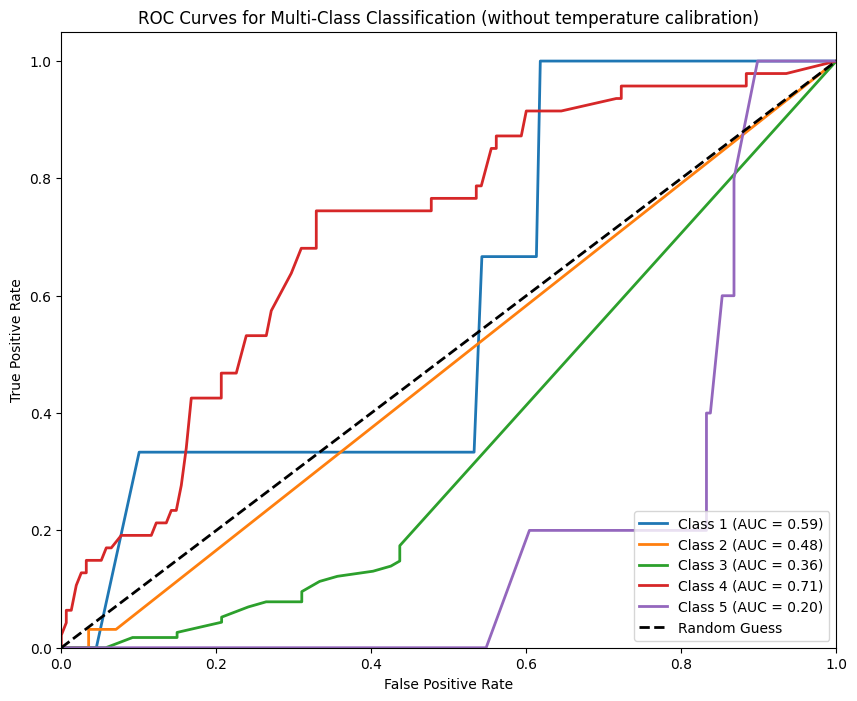

In [275]:
# Plot ROC Curves for Multi-Class (without temperature calibration)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

n_classes = y_probs.shape[1]
labels_binarized = label_binarize(numerical_labels, classes=list(range(n_classes)))
fpr = {}
tpr = {}
roc_auc_dict = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], y_probs[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i+1} (AUC = {roc_auc_dict[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", lw=2, label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification (without temperature calibration)")
plt.legend(loc="lower right")
plt.show()

In [214]:
eps = 1e-15
probs = np.clip(y_probs, eps, 1-eps)

entropy_values = -np.sum(probs * np.log2(probs), axis=1)
mean_entropy = np.mean(entropy_values)
print(f"Mean Entropy (Uncertainty): {mean_entropy:.4f}")

Mean Entropy (Uncertainty): 1.2896


In [278]:
logits = np.log(probs)

from scipy.special import softmax

def nll_loss(temperature, logits, labels):
    scaled_probs = softmax(logits / temperature, axis=1)
    n_samples = len(labels)
    nll = 0
    for i in range(n_samples):
        nll -= np.log(scaled_probs[i, labels[i]])
    return nll / n_samples

init_temp = 1.0
initial_nll = nll_loss(1.0, logits, numerical_labels)

from scipy.optimize import minimize
result = minimize(
    lambda t: nll_loss(t[0], logits, numerical_labels),
    [1.0],
    method='L-BFGS-B',
    bounds=[(0.01, 100.0)]
)

optimal_temperature = result.x[0]
min_nll = result.fun

print(f"Optimal Temperature: {optimal_temperature:.4f}")
print(f"NLL before calibration: {initial_nll:.4f}")
print(f"NLL after calibration: {min_nll:.4f}")
print(f"NLL Improvement: {initial_nll - min_nll:.4f}")

Optimal Temperature: 100.0000
NLL before calibration: 22.1561
NLL after calibration: 1.7063
NLL Improvement: 20.4498


In [279]:
# Apply temperature scaling
scaled_logits = logits / optimal_temperature
calibrated_probs = softmax(scaled_logits, axis=1)

calibrated_entropy_values = -np.sum(calibrated_probs * np.log2(calibrated_probs), axis=1)
calibrated_mean_entropy = np.mean(calibrated_entropy_values)
print(f"Calibrated Mean Entropy (Uncertainty): {calibrated_mean_entropy:.4f}")

Calibrated Mean Entropy (Uncertainty): 2.3056
